## Merge "final verification processed" files with mutiple subset dataset files into a single "model-level" file to be used in the next step
* run merge_rollout_and_verification_files.py "test single" config to run merge.

In [1]:
import json
import os
import glob
from pathlib import Path
from typing import List, Dict, Any

def check_schema_consistency(jsonl_files: List[str]) -> bool:
    """Check if all JSONL files have identical schema."""
    if not jsonl_files:
        return True
    
    # Read first file to get reference schema
    with open(jsonl_files[0], 'r') as f:
        first_line = f.readline().strip()
        if not first_line:
            return True
        reference_schema = set(json.loads(first_line).keys())
    
    # Check all other files
    for file_path in jsonl_files[1:]:
        with open(file_path, 'r') as f:
            first_line = f.readline().strip()
            if not first_line:
                continue
            current_schema = set(json.loads(first_line).keys())
            if current_schema != reference_schema:
                print(f"Schema mismatch in {file_path}")
                print(f"Expected: {reference_schema}")
                print(f"Found: {current_schema}")
                return False
    
    return True

def flatten_jsonl_files(input_files: List[str], output_file: str) -> int:
    """Flatten multiple JSONL files into a single JSONL file."""
    total_lines = 0
    
    with open(output_file, 'w') as outfile:
        for file_path in input_files:
            print(f"Processing {file_path}...")
            with open(file_path, 'r') as infile:
                for line in infile:
                    line = line.strip()
                    if line:  # Skip empty lines
                        outfile.write(line + '\n')
                        total_lines += 1
    
    return total_lines

In [2]:
import os
import glob
from collections import defaultdict

dataset_subset_split_mapping = {
    "CLEVR": ["CLEVR_first_5k", "CLEVR_second_5k"],
    "RAVEN": ["center_single", "distribute_four", "distribute_nine", "in_center_single_out_center_single_train", "in_distribute_four_out_center_single_train", "left_center_single_right_center_single_train", "up_center_single_down_center_single_train"],
    "dvqa": ["dvqa_first_5k", "dvqa_second_5k", "dvqa_third_5k"]
}

# Configuration
dataset_name = "dvqa"
models = ["gpt-4.1-mini", "gpt-4.1-nano", "o4-mini"]
input_dir = f"/mnt/fast10/brandon/mmr_rollout_data/merged_verification_files/{dataset_name}" #TODO: Create the folder (it will not exist automatically yet)
output_dir = f"/mnt/fast10/brandon/mmr_rollout_data/merged_verification_files/model_level_merged_files/{dataset_name}"


# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Get subsets for the current dataset
subsets = dataset_subset_split_mapping.get(dataset_name, [])
print(f"Processing dataset: {dataset_name}")
print(f"Subsets: {subsets}")

# Process each model
for model in models:
    print(f"\n=== Processing model: {model} ===")
    
    # Find all files for this model across all subsets
    model_files = []
    for subset in subsets:
        filename = f"{dataset_name}_final_verification_processed_{model}_{subset}.jsonl"
        file_path = os.path.join(input_dir, filename)
        
        if os.path.exists(file_path):
            model_files.append(file_path)
            print(f"Found: {filename}")
        else:
            print(f"Missing: {filename}")
    
    if not model_files:
        print(f"No files found for model {model}")
        continue
    
    print(f"Files to merge: {len(model_files)}")
    
    # Check schema consistency
    print(f"\nChecking schema consistency...")
    if not check_schema_consistency(model_files):
        print(f"ERROR: Schema mismatch detected in {model}. Skipping flattening.")
        continue
    
    print("Schema check passed!")

    # Flatten files
    output_file = f"{output_dir}/{dataset_name}_final_subset_merged_verification_processed_{model}.jsonl"
    print(f"Merging to {output_file}...")
    
    total_lines = flatten_jsonl_files(model_files, output_file)
    print(f"Successfully merged {total_lines} lines to {output_file}")

print("\n=== All models processed ===")

Processing dataset: dvqa
Subsets: ['dvqa_first_5k', 'dvqa_second_5k', 'dvqa_third_5k']

=== Processing model: gpt-4.1-mini ===
Found: dvqa_final_verification_processed_gpt-4.1-mini_dvqa_first_5k.jsonl
Found: dvqa_final_verification_processed_gpt-4.1-mini_dvqa_second_5k.jsonl
Found: dvqa_final_verification_processed_gpt-4.1-mini_dvqa_third_5k.jsonl
Files to merge: 3

Checking schema consistency...
Schema check passed!
Merging to /mnt/fast10/brandon/mmr_rollout_data/merged_verification_files/model_level_merged_files/dvqa/dvqa_final_subset_merged_verification_processed_gpt-4.1-mini.jsonl...
Processing /mnt/fast10/brandon/mmr_rollout_data/merged_verification_files/dvqa/dvqa_final_verification_processed_gpt-4.1-mini_dvqa_first_5k.jsonl...
Processing /mnt/fast10/brandon/mmr_rollout_data/merged_verification_files/dvqa/dvqa_final_verification_processed_gpt-4.1-mini_dvqa_second_5k.jsonl...
Processing /mnt/fast10/brandon/mmr_rollout_data/merged_verification_files/dvqa/dvqa_final_verification_pro

# Take merged verification files and merge them with the rollout files (use merge_rollout_and_verification_files.py for this)

In [3]:
import json

file_path = "/mnt/fast10/brandon/mmr_rollout_data/flattened_rollout_files/dvqa_flattened.jsonl"

with open(file_path, "r") as f:
    first = next(f)
    row = json.loads(first)
    print("Columns:", list(row.keys()))
    print("First row key: value pairs:")
    for k, v in row.items():
        print(f"{k}: {v}")

Columns: ['image', 'question', 'answer', 'uid', 'image_path', 'response', 'steps_with_score']
First row key: value pairs:
image: MMPR-v1.2-prompts/correctness_images/dvqa_en_20240402_extracted_int_only/images/bar_train_00093673.png
question: You are an expert data analyst specializing in interpreting data visualizations. Your task is to answer questions about charts and graphs presented to you in images. You will be provided with an image containing one or more data visualizations and a specific question about the data presented.

I will provide you with an image containing:
- Data Visualization: A chart or graph that contains data points and other visual elements.

Here's the question you need to answer:

<question>
How many people prefer the objects bass or figure? Answer the question using a single word or phrase.
</question>

Please follow these steps to complete the task:

1. Carefully examine the image, paying attention to all elements of the data visualization(s) such as titles,

In [6]:
import json

file_path = "/mnt/fast10/brandon/mmr_rollout_data/flattened_rollout_files/CLEVR_flattened.jsonl"

with open(file_path, "r") as f:
    first = next(f)
    row = json.loads(first)
    print("Columns:", list(row.keys()))

Columns: ['image', 'question', 'answer', 'uid', 'image_path', 'response', 'steps_with_score']


In [6]:
import re
import json

model_name = "o4-mini"
dataset_name = "AI2D"
merged_verification_file = f"/mnt/fast10/brandon/mmr_rollout_data/merged_verification_files/{dataset_name}_final_verification_processed_{model_name}.jsonl"
# output_path = f"/mnt/fast10/brandon/mmr_rollout_data/processed_full_verification_files/{dataset_name}_final_mc_and_verification_merged_{model_name}.jsonl"

# Extract verification_solutions from merged file
verification_solutions = []
solution_pattern = re.compile(r'<solution>(.*?)</solution>', re.DOTALL)

with open(merged_verification_file, 'r') as f:
    for line_num, line in enumerate(f, 1):
        item = json.loads(line)
        try:
            text = item["body"]["messages"][0]["content"][0]["text"]
            # Find all matches and get the second one
            matches = solution_pattern.findall(text)
            if len(matches) >= 2:
                solution_text = matches[1].strip()  # Get second occurrence
                if solution_text:  # Only add non-emptyverification_solutions 
                    verification_solutions.append({
                        "custom_id": item.get("custom_id", "ERROR: custom_id not found"),
                        "unique_key": solution_text,
                        "verification_response": item.get("verification_response", "ERROR: verification_response not found"),
                        "o4-mini_isVerified": item.get("o4-mini_isVerified", "ERROR: o4-mini_isVerified not found")
                    })
            elif len(matches) == 1:
                print(f"Warning: Only one <solution> tag found in line {line_num}")
            else:
                print(f"Warning: No <solution> tags found in line {line_num}")
        except (KeyError, IndexError, TypeError) as e:
            print(f"Error accessing text in line {line_num}: {e}")

print(f"Extracted {len(verification_solutions)} valid verification_solutions")

Extracted 24595 valid verification_solutions


In [7]:
# Load flattened file once into memory
full_raw_rollout_data_file = "/mnt/fast10/brandon/mmr_rollout_data/flattened_rollout_files/AI2D_flattened.jsonl"
full_raw_rollout_data_array = []

with open(full_raw_rollout_data_file, 'r') as f:
    for line in f:
        item = json.loads(line)
        full_raw_rollout_data_array.append({
            "response": item.get("response", ""),
            "response_uid": item.get("uid", ""),
            "image_path": item.get("image_path", ""),
        })

print(f"Loaded {len(full_raw_rollout_data_array)} items from flattened file")

Loaded 25557 items from flattened file


In [8]:
full_raw_rollout_data_array[0].keys()

print(full_raw_rollout_data_array[0].keys())


for k,v in full_raw_rollout_data_array[0].items():
    print(k)
    print(v)

dict_keys(['response', 'response_uid', 'image_path'])
response
[Visual Elements]
<step_1>
Identify all organisms in the food web: short-eared owl, vole, meadow pippit, emperor moth larvae, red grouse, heather, fox, brown hare, red kite or hen harrier.
</step_1>
<step_2>
Note the arrows indicating feeding relationships: arrows point from food to consumer.
</step_2>
<step_3>
Observe that the fox eats: red grouse, brown hare, and vole (arrows pointing from each of these to fox).
</step_3>
<step_4>
Determine what eats fox: no arrows point to fox, indicating it is a top predator.
</step_4>
<step_5>
Determine what else eats red grouse: Arrow from red grouse to fox, and red kite or hen harrier. So red grouse is eaten by fox and red kite/hen harrier.
</step_5>
<step_6>
Determine who eats meadow pippit: Arrow from meadow pippit to fox only.
</step_6>
<step_7>
Note which options are present: more grouse, more pippit, less grouse, less owl.
</step_7>

[Reasoning]
<step_1>
The question asks what w

In [ ]:


print(verification_solutions[0].keys())

for k,v in verification_solutions[0].items():
    print(k)
    print(v)

dict_keys(['custom_id', 'unique_key', 'verification_response', 'o4-mini_isVerified'])
custom_id
738acf33-13b2-4336-8720-5ca2cf6503a8
unique_key
[Visual Elements]
<step_1>
The image is a labeled diagram of an animal cell, showing its various organelles.
</step_1>
<step_2>
Key organelles visible and labeled in the image include: Golgi apparatus, Mitochondrion, Nucleus, Cytoplasm, Endoplasmic reticulum, Lysosome, Centriole, Ribosomes, Nucleolus, Genetic material (DNA), Nuclear membrane, and Plasma membrane.
</step_2>
<step_3>
The label “Mitochondrion” is present and points to oblong, orange organelles scattered throughout the cytoplasm.
</step_3>
<step_4>
The label “Golgi apparatus (Golgi body)” points to a stack-like organelle.
</step_4>
<step_5>
The label “Nucleus” points to the central, large, round organelle in the cell.
</step_5>
<step_6>
The label “Cytoplasm” points to the fluid matrix filling much of the cell’s interior.
</step_6>
<step_7>
The question asks which of these organelle

In [15]:
def check_for_collisions(verification_solutions, full_raw_rollout_data_array):
    """
    Check for collisions and missing matches between verification solutions and rollout data.
    
    Returns:
        tuple: (collision_errors, no_matches_array, has_collisions, has_no_matches)
    """
    collision_errors = []
    no_matches_array = []
    
    for sol in verification_solutions:
        unique_key = sol["unique_key"]
        
        # Find all matches
        matches = [item for item in full_raw_rollout_data_array if item["response"].strip() == unique_key]
        
        if len(matches) > 1:
            collision_errors.append({
                "solution_unique_key": unique_key,
                "solution_custom_id": sol["custom_id"],
                "matches": matches
            })
        elif len(matches) == 0:
            no_matches_array.append({
                "solution_unique_key": unique_key,
                "solution_custom_id": sol["custom_id"],
            })

    # Report collision errors
    has_collisions = len(collision_errors) > 0
    has_no_matches = len(no_matches_array) > 0
    
    if has_collisions:
        print(f"\n�� COLLISION ERRORS FOUND: {len(collision_errors)} unique_keys have multiple matches!")
        for error in collision_errors:
            print(f"\nCollision for solution_custom_id: {error['solution_custom_id']}")
            print(f"solution_unique_key: {error['solution_unique_key'][:100]}...")
            print(f"Found {len(error['matches'])} matches:")
            for match in error['matches']:
                print(f"  - response_uid: {match['response_uid']}, response: {match['response'][:50]}...")
    else:
        print(f"\n✅ No collisions found! All {len(verification_solutions)} solutions have at most one match.")

    if has_no_matches:
        print(f"\n🚨 NO MATCHES FOUND: {len(no_matches_array)} unique_keys have no matches!")
        for error in no_matches_array:
            print(f"\nNo match found for solution_custom_id: {error['solution_custom_id']}")
            print(f"solution_unique_key: {error['solution_unique_key'][:100]}...")
    else:
        print(f"\n✅ No no matches found! All {len(verification_solutions)} solutions have at least one match.")
    
    return collision_errors, no_matches_array, has_collisions, has_no_matches

# Test the function
# collision_errors, no_matches_array, has_collisions, has_no_matches = check_for_collisions(
#     verification_solutions, full_raw_rollout_data_array
# )

In [ ]:
def merge_rollout_and_verification_data(verification_solutions, full_raw_rollout_data_array, output_path):
    """
    Merge verification solutions with rollout data when no collisions are detected.
    Uses full_raw_rollout_data_array as the reference point.
    
    Args:
        verification_solutions: List of verification solution dicts
        full_raw_rollout_data_array: List of rollout data dicts
        output_path: Path to save the merged output file
    """
    # First check for collisions
    collision_errors, no_matches_array, has_collisions, has_no_matches = check_for_collisions(
        verification_solutions, full_raw_rollout_data_array
    )
    
    if has_collisions:
        raise ValueError(f"{len(collision_errors)} collision errors found. Cannot proceed with merge.")
    
    # Create lookup dictionary for verification solutions
    verification_lookup = {sol["unique_key"]: sol for sol in verification_solutions}
    
    # Initialize trackers
    rollouts_without_verification = 0
    rollouts_with_verification = 0
    invalid_verification_values = []
    
    # Merge the data - iterate over rollout data as reference
    merged_data = []
    for rollout_item in full_raw_rollout_data_array:
        response_key = rollout_item["response"].strip()
        
        # Check if this rollout has a corresponding verification solution
        if response_key in verification_lookup:
            # Found matching verification solution
            verification_sol = verification_lookup[response_key]
            
            # Validate o4-mini_isVerified value
            is_verified_value = verification_sol.get("o4-mini_isVerified")
            if is_verified_value not in [True, False]:
                invalid_verification_values.append({
                    "o4-mini_verification_custom_id": verification_sol["custom_id"],
                    "o4-mini_verification_response": verification_sol["verification_response"],
                    "o4-mini_isVerified_value": is_verified_value,
                    "type": type(is_verified_value).__name__
                })
            
            merged_item = {
                "o4-mini_verification_custom_id": verification_sol["custom_id"],
                "response_uid": rollout_item["response_uid"],
                "rollout_response": rollout_item["response"],
                "rollout_image_path": rollout_item["image_path"],
                "o4-mini_verification_solution": verification_sol["verification_response"],
                "o4-mini_isVerified": is_verified_value
            }
            rollouts_with_verification += 1
        else:
            # No matching verification solution found
            merged_item = {
                "o4-mini_verification_custom_id": None,
                "response_uid": rollout_item["response_uid"],
                "rollout_response": rollout_item["response"],
                "rollout_image_path": rollout_item["image_path"],
                "o4-mini_verification_solution": None,
                "o4-mini_isVerified": None
            }
            rollouts_without_verification += 1
        
        merged_data.append(merged_item)
    
    # Save to file
    with open(output_path, 'w') as f:
        for item in merged_data:
            f.write(json.dumps(item) + '\n')
    
    print(f"\n✅ Successfully merged {len(merged_data)} items to {output_path}")
    print(f"📊 Summary:")
    print(f"   - Rollouts with verification: {rollouts_with_verification}")
    print(f"   - Rollouts without verification: {rollouts_without_verification}")
    print(f"   - Total rollouts: {len(merged_data)}")
    
    # Report invalid verification values
    if invalid_verification_values:
        print(f"\n⚠️  INVALID VERIFICATION VALUES FOUND: {len(invalid_verification_values)} items. None values acceptable, means the verification returned an error.")
        print("These custom_ids have invalid o4-mini_isVerified values (not True/False):")
        for item in invalid_verification_values:
            print(f"   - verification_custom_id: {item['verification_custom_id']}, o4-mini_isVerified_value: {item['o4-mini_isVerified_value']}, verification_response: {item['verification_response']} (type: {item['type']})")
    else:
        print(f"\n✅ All verification values are valid (True/False)")
    
    return merged_data

# Define output path and run merge
output_path = f"/mnt/fast10/brandon/mmr_rollout_data/processed_full_verification_files/{dataset_name}_final_mc_and_verification_merged_{model_name}.jsonl"

merged_data = merge_rollout_and_verification_data(
    verification_solutions, 
    full_raw_rollout_data_array, 
    output_path
)


✅ No collisions found! All 24595 solutions have at most one match.

✅ No no matches found! All 24595 solutions have at least one match.

✅ Successfully merged 25557 items to /mnt/fast10/brandon/mmr_rollout_data/processed_full_verification_files/AI2D_final_mc_and_verification_merged_o4-mini.jsonl
📊 Summary:
   - Rollouts with verification: 24595
   - Rollouts without verification: 962
   - Total rollouts: 25557

⚠️  INVALID VERIFICATION VALUES FOUND: 2 items
These custom_ids have invalid o4-mini_isVerified values (not True/False):
   - verification_custom_id: 203288af-ef39-41da-bff6-5184ad83b951, o4-mini_isVerified_value: None, verification_response:  (type: NoneType)
   - verification_custom_id: c0cb3f17-b910-4df7-9c55-f2e34f0f4039, o4-mini_isVerified_value: None, verification_response:  (type: NoneType)


In [3]:
# Load and print all values from the merged verification file
import json

# File path
# file_path = "/mnt/fast10/brandon/mmr_rollout_data/prm_training_data/train/AI2D_final_mc_rollouts_with_all_models_verification_merged_prm_training_data.jsonl"

file_path = "/mnt/fast10/brandon/mmr_rollout_data/final_combined_MC_and_verification_files/AI2D_final_mc_rollouts_with_all_models_verification_merged.jsonl"

print(f"📁 Loading data from: {file_path}")
print("=" * 80)

import pandas as pd

# Load JSONL file into DataFrame
df = pd.read_json(file_path, lines=True)
print(f"✅ Loaded {len(df)} rows into df")
print(df.head())

📁 Loading data from: /mnt/fast10/brandon/mmr_rollout_data/final_combined_MC_and_verification_files/AI2D_final_mc_rollouts_with_all_models_verification_merged.jsonl
✅ Loaded 25557 rows into df
                           response_uid  \
0  b6c24365-7b04-4a00-96fb-4ed28c9fcdfc   
1  b6c24365-7b04-4a00-96fb-4ed28c9fcdfc   
2  b6c24365-7b04-4a00-96fb-4ed28c9fcdfc   
3  b6c24365-7b04-4a00-96fb-4ed28c9fcdfc   
4  b77157ea-dcee-44a6-be87-2e5e8db7ca2b   

                                    rollout_question  \
0  You are an advanced visual reasoning AI specia...   
1  You are an advanced visual reasoning AI specia...   
2  You are an advanced visual reasoning AI specia...   
3  You are an advanced visual reasoning AI specia...   
4  You are an advanced visual reasoning AI specia...   

                                    rollout_response rollout_answer  \
0  [Visual Elements]\n<step_1>\nIdentify all orga...    more grouse   
1  [Visual Elements]\n<step_1>\nThe food web diag...    more grouse   

In [5]:
df_selected = df[df["response_uid"] == "bfab4a1a-fcd5-4c14-b7e7-fc9d29e81613"]
print(df_selected)

                             response_uid  \
581  bfab4a1a-fcd5-4c14-b7e7-fc9d29e81613   
582  bfab4a1a-fcd5-4c14-b7e7-fc9d29e81613   
583  bfab4a1a-fcd5-4c14-b7e7-fc9d29e81613   
584  bfab4a1a-fcd5-4c14-b7e7-fc9d29e81613   

                                      rollout_question  \
581  You are an advanced visual reasoning AI specia...   
582  You are an advanced visual reasoning AI specia...   
583  You are an advanced visual reasoning AI specia...   
584  You are an advanced visual reasoning AI specia...   

                                      rollout_response      rollout_answer  \
581  [Visual Elements]\n<step_1>\nThe diagram shows...  oblique-slip fault   
582  [Visual Elements]\n<step_1>\nThe diagram shows...  oblique-slip fault   
583  [Visual Elements]\n<step_1>\nThe diagram shows...  oblique-slip fault   
584  [Visual Elements]\n<step_1>\nTwo large blocks ...  oblique-slip fault   

                              rollout_steps_with_score  \
581  [{'step': 'The diagram shows 

In [6]:
print(df.columns)

Index(['id', 'image_url', 'conversations', 'first_incorrect_step',
       'steps_with_score'],
      dtype='object')


In [4]:
df["gpt_4.1_mini_isVerified"].iloc[0]

np.float64(1.0)

In [7]:
print(df["rollout_response"].iloc[0])
print(df["rollout_steps_with_score"].iloc[0])
print(df["o4_mini_verification_solution"].iloc[10])

[Visual Elements]
<step_1>
Identify all organisms in the food web: short-eared owl, vole, meadow pippit, emperor moth larvae, red grouse, heather, fox, brown hare, red kite or hen harrier.
</step_1>
<step_2>
Note the arrows indicating feeding relationships: arrows point from food to consumer.
</step_2>
<step_3>
Observe that the fox eats: red grouse, brown hare, and vole (arrows pointing from each of these to fox).
</step_3>
<step_4>
Determine what eats fox: no arrows point to fox, indicating it is a top predator.
</step_4>
<step_5>
Determine what else eats red grouse: Arrow from red grouse to fox, and red kite or hen harrier. So red grouse is eaten by fox and red kite/hen harrier.
</step_5>
<step_6>
Determine who eats meadow pippit: Arrow from meadow pippit to fox only.
</step_6>
<step_7>
Note which options are present: more grouse, more pippit, less grouse, less owl.
</step_7>

[Reasoning]
<step_1>
The question asks what would happen if the fox population decreased. Fox is a predator 

In [2]:
# Load and print all values from the merged verification file
import json

# File path
file_path = "/mnt/fast10/brandon/mmr_rollout_data/prm_training_data/train/AI2D_final_mc_rollouts_with_all_models_verification_merged_prm_training_data_final_trl_format.jsonl"

print(f"📁 Loading data from: {file_path}")
print("=" * 80)

import pandas as pd

# Load JSONL file into DataFrame
df = pd.read_json(file_path, lines=True)
print(f"✅ Loaded {len(df)} rows into df")
print(df.head())

📁 Loading data from: /mnt/fast10/brandon/mmr_rollout_data/prm_training_data/train/AI2D_final_mc_rollouts_with_all_models_verification_merged_prm_training_data_final_trl_format.jsonl
✅ Loaded 11741 rows into df
                                            messages  \
0  [{'role': 'system', 'content': [{'type': 'text...   
1  [{'role': 'system', 'content': [{'type': 'text...   
2  [{'role': 'system', 'content': [{'type': 'text...   
3  [{'role': 'system', 'content': [{'type': 'text...   
4  [{'role': 'system', 'content': [{'type': 'text...   

                                              images  \
0  [s3://arf-share/arf-ob1-mm-reasoning/training_...   
1  [s3://arf-share/arf-ob1-mm-reasoning/training_...   
2  [s3://arf-share/arf-ob1-mm-reasoning/training_...   
3  [s3://arf-share/arf-ob1-mm-reasoning/training_...   
4  [s3://arf-share/arf-ob1-mm-reasoning/training_...   

                                     id  
0  0000c1f9-7515-4ecf-8cf0-7bd300e2da56  
1  0004d758-9ef4-4b33-a33d-59679

In [8]:
df.columns
print(df["images"].iloc[0])

import boto3
from io import BytesIO
from PIL import Image

image_url = df["images"].iloc[0][0]

def is_s3_url(url):
    return url.startswith("s3://")

def load_s3_image_with_pillow(s3_url):
    path = s3_url[5:]
    bucket, key = path.split("/", 1)
    s3 = boto3.client("s3")
    try:
        obj = s3.get_object(Bucket=bucket, Key=key)
        img_bytes = obj["Body"].read()
        img = Image.open(BytesIO(img_bytes))
        img.verify()  # Will raise if not a valid image
        print(f"✅ PIL successfully loaded image from: {s3_url}")
        return img
    except Exception as e:
        print(f"❌ PIL failed to load image from: {s3_url}\n{e}")
        return None

img = None
if is_s3_url(image_url):
    img = load_s3_image_with_pillow(image_url)
else:
    print(f"❌ Not an S3 URL, skipping: {image_url}")

['s3://arf-share/arf-ob1-mm-reasoning/training_data_images/AI2D/subset_images/706.png']
✅ PIL successfully loaded image from: s3://arf-share/arf-ob1-mm-reasoning/training_data_images/AI2D/subset_images/706.png


In [14]:
import os
import boto3
import base64
import io
from openai import OpenAI
from PIL import Image

def load_image_from_s3(s3_url):
    """Load image from S3 URL and return PIL Image object"""
    from urllib.parse import urlparse
    
    # Parse S3 URL: s3://bucket-name/path/to/file.jpg
    parsed = urlparse(s3_url)
    bucket_name = parsed.netloc
    key = parsed.path.lstrip('/')
    
    s3_client = boto3.client('s3')
    response = s3_client.get_object(Bucket=bucket_name, Key=key)
    image_data = response['Body'].read()
    return Image.open(io.BytesIO(image_data))

def encode_image_to_base64(img, format="JPEG"):
    """Convert PIL image to base64 string"""
    img_bytes = io.BytesIO()
    img.save(img_bytes, format=format)
    img_bytes.seek(0)
    return base64.b64encode(img_bytes.read()).decode("utf-8")

def run_openai_inference(base64_image, prompt="What's in this image?", model="gpt-4.1-nano"):
    """Run OpenAI inference on base64 encoded image"""
    client = OpenAI(api_key="")
    
    completion = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}",
                        },
                    },
                ],
            }
        ],
    )
    return completion.choices[0].message.content

# Main function - put it all together
def process_s3_image(s3_url, prompt="What's in this image?"):
    """Complete pipeline: S3 → PIL → Base64 → OpenAI inference"""
    try:
        # 1. Load from S3
        img = load_image_from_s3(s3_url)
        print(f"✅ Loaded image from {s3_url}")
        
        # 2. Encode to base64
        base64_image = encode_image_to_base64(img)
        print(f"✅ Encoded image to base64 ({len(base64_image)} chars)")
        
        # 3. Run OpenAI inference
        result = run_openai_inference(base64_image, prompt)
        print(f"🤖 OpenAI response: {result}")
        
        return result
        
    except Exception as e:
        print(f"❌ Error: {e}")
        return None

# Example usage
if __name__ == "__main__":
    # Replace with your S3 URL
    s3_url = "s3://arf-share/arf-ob1-mm-reasoning/training_data_images/AI2D/subset_images/78.png"
    
    result = process_s3_image(s3_url, "Describe this image in detail") 

✅ Loaded image from s3://arf-share/arf-ob1-mm-reasoning/training_data_images/AI2D/subset_images/78.png
✅ Encoded image to base64 (69028 chars)
🤖 OpenAI response: The image appears to depict a cycle or system involving various elements, represented by blocks labeled with letters. Here's a detailed description:

- The sequence is arranged in a circular flow, with arrows connecting the elements.
- Starting from the top and moving clockwise:
  - **E**: A cloud with raindrops, possibly symbolizing weather or water source.
  - **B**: A larger rectangular block beneath the cloud, likely representing a central component or resource.
  - **I**: A long rectangular bar extending outward from B, though unclear what it symbolizes.
  - **J**: An image of a bird (possibly an emu or similar bird), indicating fauna or wildlife.
  - **D**: An image of a turtle, another example of fauna.
  - **C**: An image of cows on a farm, representing livestock or dairy farming.
  - **F**: An image of a forest with t

In [1]:
# Load and print all values from the merged verification file
import json

# File path
file_path = "/mnt/fast10/brandon/mmr_rollout_data/prm_training_data/debug/AI2D_final_mc_rollouts_with_all_models_verification_merged_prm_training_data_mc0.5.jsonl"

print(f"📁 Loading data from: {file_path}")
print("=" * 80)

import pandas as pd

# Load JSONL file into DataFrame
df = pd.read_json(file_path, lines=True)
print(f"✅ Loaded {len(df)} rows into df")
print(df.head())

📁 Loading data from: /mnt/fast10/brandon/mmr_rollout_data/prm_training_data/debug/AI2D_final_mc_rollouts_with_all_models_verification_merged_prm_training_data_mc0.5.jsonl
✅ Loaded 12406 rows into df
                                     id  \
0  0000c1f9-7515-4ecf-8cf0-7bd300e2da56   
1  0004d758-9ef4-4b33-a33d-596796155767   
2  00077821-5849-4b80-a0cb-7654c3de7514   
3  0008dddb-debc-4561-8d15-b640505879ff   
4  000b7c61-4f6c-421a-81fc-98d4979b891d   

                                           image_url  \
0  /data/users/brandon/ob1-projects/InternVL/inte...   
1  /data/users/brandon/ob1-projects/InternVL/inte...   
2  /data/users/brandon/ob1-projects/InternVL/inte...   
3  /data/users/brandon/ob1-projects/InternVL/inte...   
4  /data/users/brandon/ob1-projects/InternVL/inte...   

                                       conversations first_incorrect_step  \
0  [{'from': 'system', 'value': 'You are an advan...                 None   
1  [{'from': 'system', 'value': 'You are an advan..

In [2]:

# Count rows where first_incorrect_step is not None
incorrect_samples_df = df[df['first_incorrect_step'].notna()]
print(len(incorrect_samples_df))
print(incorrect_samples_df["first_incorrect_step"].iloc[0])

6
['Visual Elements', 1]


In [3]:
incorrect_samples_df.columns
print(incorrect_samples_df["image_url"].iloc[0])

/data/users/brandon/ob1-projects/InternVL/internvl_chat/rollout_generation/preprocessed_prompts/preprocessing_scripts/AI2D/subset_images/78.png


In [ ]:
print(incorrect_samples_df["first_incorrect_step"].iloc[0])
incorrect_samples_df["conversations"].iloc[0][1::]

['Visual Elements', 1]


[{'from': 'human',
  'value': '### Question:\nYou are an advanced visual reasoning AI specialized in analyzing images for the Visual Question Answering (VQA) task. Your objective is to examine images containing various objects, scenes, geometric shapes, diagram elements, and potentially text or numbers, and reason about processes or changes, and answer questions about their attributes, relationships, and spatial arrangements.\n\nI will provide you with:\n\n1. An image containing science diagrams\n2. A question about the contents of the image\n\nHere is the question you need to answer:\n\n<question>\nWhat is the process at letter J called in the diagram?\nphotosynthesis\ncellular respiration\ndecay by fungi and bacteria\nconsumption\nPlease answer the question based on the options mentioned before.\n</question>\n\nPlease follow these steps to complete the task:\n\n1. Carefully examine the image, paying attention to:\n   - Objects and scenes present\n   - Geometric shapes (if any)\n   - 

In [4]:
print(df["image_path"].iloc[0])
print(df["conversations"].iloc[0])

KeyError: 'image_path'

# Analyze Distribution

Total rows loaded: 23947
Columns: ['prompt_uid', 'rollout_question', 'rollout_response', 'rollout_ground_truth_answer', 'rollout_steps_with_score', 'rollout_image_path', 'rollout_uuid', 'o4_mini_verification_custom_id', 'o4_mini_verification_solution', 'o4_mini_isVerified', 'gpt_4.1_mini_verification_custom_id', 'gpt_4.1_mini_verification_solution', 'gpt_4.1_mini_isVerified', 'gpt_4.1_nano_verification_custom_id', 'gpt_4.1_nano_verification_solution', 'gpt_4.1_nano_isVerified']

=== DATASET OVERVIEW ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23947 entries, 0 to 23946
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   prompt_uid                           23947 non-null  object
 1   rollout_question                     23947 non-null  object
 2   rollout_response                     23947 non-null  object
 3   rollout_ground_truth_answer          23947 non-null 

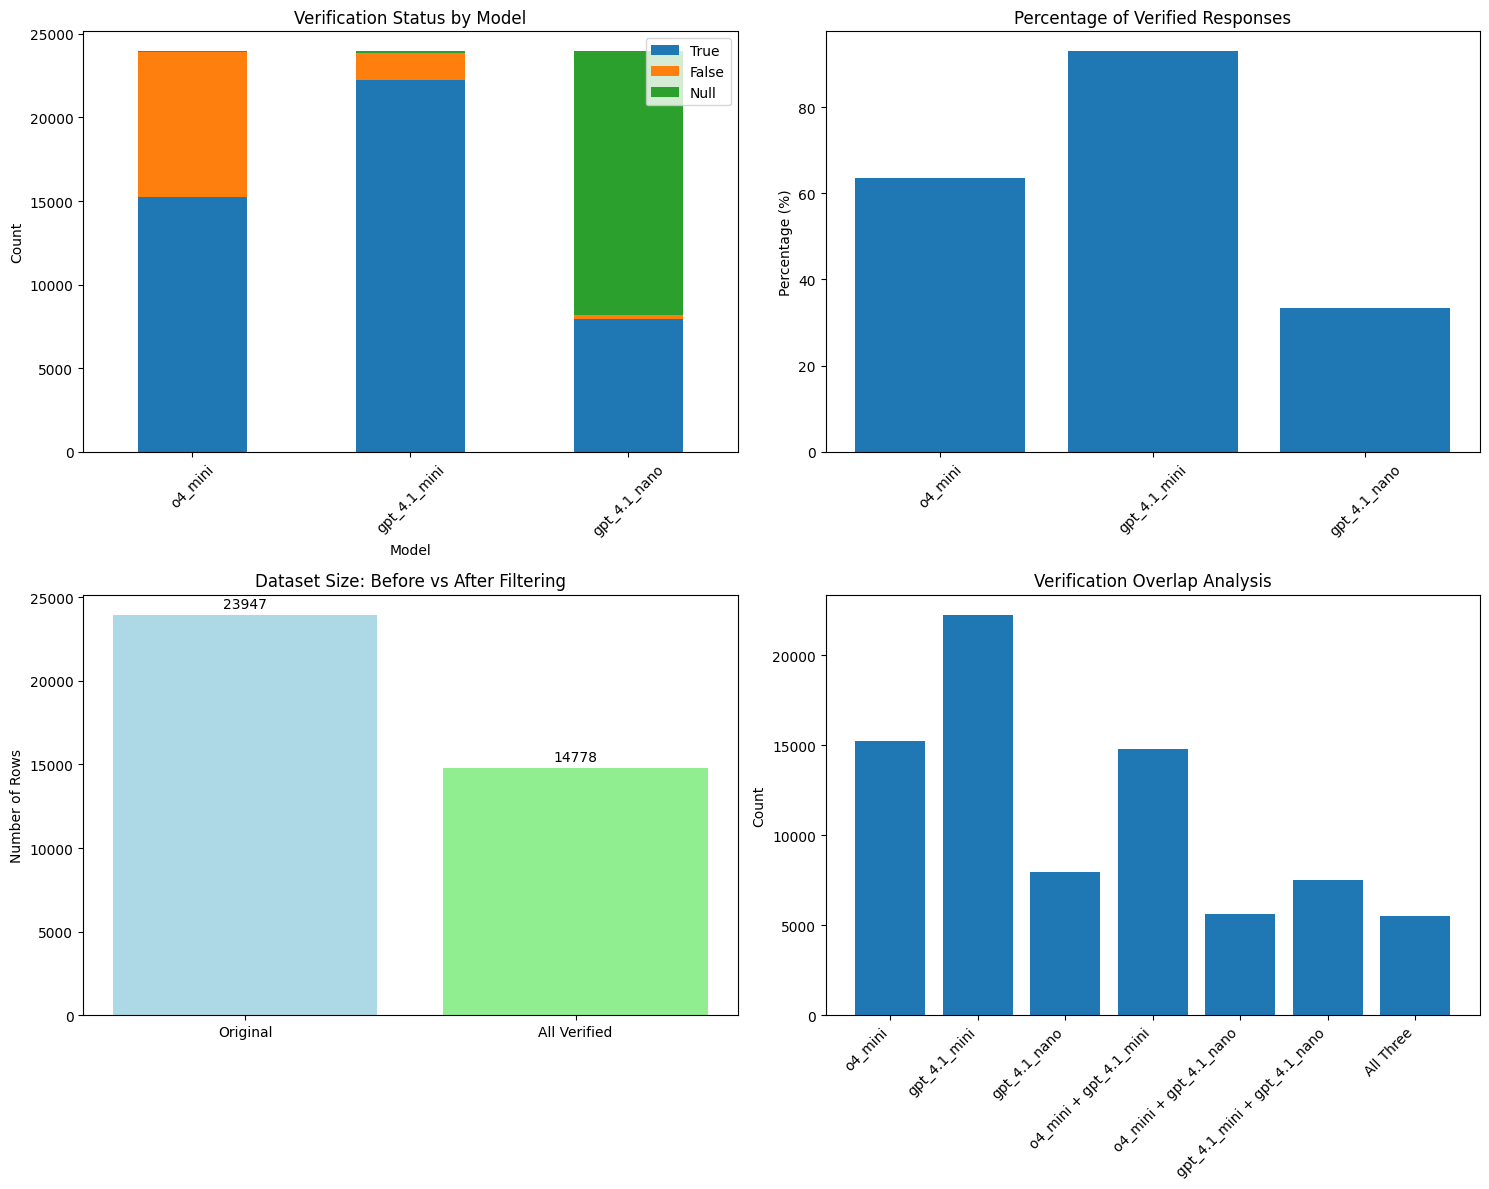


=== SAMPLE OF FILTERED DATA (First 3 rows) ===
  rollout_ground_truth_answer o4_mini_isVerified gpt_4.1_mini_isVerified  \
1                           1               True                    True   
4                          29               True                    True   
5                           2               True                    True   

  gpt_4.1_nano_isVerified  
1                    None  
4                    None  
5                    True  

=== FILTERED DATASET STATISTICS ===
Average rollout answer length: 2.18 characters
Unique rollout answers: 727
Most common rollout answers:
rollout_ground_truth_answer
1    1081
2    1011
0     768
3     584
4     486
Name: count, dtype: int64


In [6]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the JSONL file
file_path = "processed_full_verification_files/vqav2_final_mc_rollouts_with_all_models_verification_merged.jsonl"

# Read JSONL file
data = []
with open(file_path, 'r') as f:
    for line in f:
        data.append(json.loads(line.strip()))

# Convert to DataFrame
df = pd.DataFrame(data)

print(f"Total rows loaded: {len(df)}")
print(f"Columns: {list(df.columns)}")

# Display basic info
print("\n=== DATASET OVERVIEW ===")
print(df.info())

# Summary statistics for verification columns
verification_cols = ['o4_mini_isVerified', 'gpt_4.1_mini_isVerified', 'gpt_4.1_nano_isVerified']

print("\n=== VERIFICATION STATUS SUMMARY ===")
for col in verification_cols:
    if col in df.columns:
        print(f"\n{col}:")
        print(df[col].value_counts(dropna=False))
        print(f"True percentage: {df[col].sum() / len(df) * 100:.2f}%")

# Create summary plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Verification status for each model
verification_data = []
for col in verification_cols:
    if col in df.columns:
        true_count = df[col].sum()
        false_count = (df[col] == False).sum()
        null_count = df[col].isna().sum()
        verification_data.append({
            'Model': col.replace('_isVerified', ''),
            'True': true_count,
            'False': false_count,
            'Null': null_count
        })

if verification_data:
    verification_df = pd.DataFrame(verification_data)
    verification_df.set_index('Model').plot(kind='bar', stacked=True, ax=axes[0,0])
    axes[0,0].set_title('Verification Status by Model')
    axes[0,0].set_ylabel('Count')
    axes[0,0].tick_params(axis='x', rotation=45)

# Plot 2: Percentage of verified responses
if verification_data:
    percentages = []
    models = []
    for row in verification_data:
        total = row['True'] + row['False'] + row['Null']
        if total > 0:
            percentages.append(row['True'] / total * 100)
            models.append(row['Model'])
    
    axes[0,1].bar(models, percentages)
    axes[0,1].set_title('Percentage of Verified Responses')
    axes[0,1].set_ylabel('Percentage (%)')
    axes[0,1].tick_params(axis='x', rotation=45)

# Filter for all three models verified
print("\n=== FILTERING FOR ALL MODELS VERIFIED ===")
all_verified_mask = df[verification_cols].all(axis=1)
filtered_df = df[all_verified_mask]

print(f"Original rows: {len(df)}")
print(f"Rows after filtering (all verified): {len(filtered_df)}")
print(f"Percentage filtered out: {(len(df) - len(filtered_df)) / len(df) * 100:.2f}%")
print(f"Percentage remaining: {len(filtered_df) / len(df) * 100:.2f}%")

# Plot 3: Before vs After filtering
axes[1,0].bar(['Original', 'All Verified'], [len(df), len(filtered_df)], color=['lightblue', 'lightgreen'])
axes[1,0].set_title('Dataset Size: Before vs After Filtering')
axes[1,0].set_ylabel('Number of Rows')
for i, v in enumerate([len(df), len(filtered_df)]):
    axes[1,0].text(i, v + max(len(df), len(filtered_df)) * 0.01, str(v), ha='center', va='bottom')

# Plot 4: Verification overlap analysis
if all(col in df.columns for col in verification_cols):
    # Create Venn diagram-like analysis
    o4_verified = df['o4_mini_isVerified'] == True
    gpt41_mini_verified = df['gpt_4.1_mini_isVerified'] == True
    gpt41_nano_verified = df['gpt_4.1_nano_isVerified'] == True
    
    overlap_data = {
        'o4_mini': o4_verified.sum(),
        'gpt_4.1_mini': gpt41_mini_verified.sum(),
        'gpt_4.1_nano': gpt41_nano_verified.sum(),
        'o4_mini + gpt_4.1_mini': (o4_verified & gpt41_mini_verified).sum(),
        'o4_mini + gpt_4.1_nano': (o4_verified & gpt41_nano_verified).sum(),
        'gpt_4.1_mini + gpt_4.1_nano': (gpt41_mini_verified & gpt41_nano_verified).sum(),
        'All Three': (o4_verified & gpt41_mini_verified & gpt41_nano_verified).sum()
    }
    
    axes[1,1].bar(range(len(overlap_data)), list(overlap_data.values()))
    axes[1,1].set_title('Verification Overlap Analysis')
    axes[1,1].set_ylabel('Count')
    axes[1,1].set_xticks(range(len(overlap_data)))
    axes[1,1].set_xticklabels(list(overlap_data.keys()), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Display sample of filtered data
print("\n=== SAMPLE OF FILTERED DATA (First 3 rows) ===")
if len(filtered_df) > 0:
    sample_cols = ['response_uid', 'rollout_ground_truth_answer'] + verification_cols
    available_cols = [col for col in sample_cols if col in filtered_df.columns]
    print(filtered_df[available_cols].head(3))
else:
    print("No rows match the filtering criteria!")

# Additional statistics on filtered data
if len(filtered_df) > 0:
    print(f"\n=== FILTERED DATASET STATISTICS ===")
    print(f"Average rollout answer length: {filtered_df['rollout_ground_truth_answer'].str.len().mean():.2f} characters")
    print(f"Unique rollout answers: {filtered_df['rollout_ground_truth_answer'].nunique()}")
    print(f"Most common rollout answers:")
    print(filtered_df['rollout_ground_truth_answer'].value_counts().head(5))

In [3]:
# Print full content of one row with all columns
if len(filtered_df) > 0:
    print("=== FULL CONTENT OF FIRST ROW ===")
    first_row = filtered_df.iloc[0]
    for col in filtered_df.columns:
        print(f"\n{col}:")
        print(f"  {first_row[col]}")
else:
    print("No data available in filtered_df")

=== FULL CONTENT OF FIRST ROW ===

response_uid:
  b77157ea-dcee-44a6-be87-2e5e8db7ca2b

rollout_question:
  You are an advanced visual reasoning AI specialized in analyzing images for the Visual Question Answering (VQA) task. Your objective is to examine images containing various objects, scenes, geometric shapes, diagram elements, and potentially text or numbers, and reason about processes or changes, and answer questions about their attributes, relationships, and spatial arrangements.

I will provide you with:

1. An image containing science diagrams
2. A question about the contents of the image

Here is the question you need to answer:

<question>
What feeds on microbial loop?
nitrogen
cladocerans
carbon
phytoplankton
Please answer the question based on the options mentioned before.
</question>

Please follow these steps to complete the task:

1. Carefully examine the image, paying attention to:
   - Objects and scenes present
   - Geometric shapes (if any)
   - Attributes of each 

In [2]:
def inspect_prm_training_data(prm_file_path, max_samples=5):
    """
    Inspect PRM training data file structure and content.
    
    Args:
        prm_file_path: Path to the PRM training data file
        max_samples: Maximum number of sample items to analyze
    """
    import json
    import os
    from collections import defaultdict
    
    print(f"🔍 Inspecting PRM training data: {prm_file_path}")
    
    if not os.path.exists(prm_file_path):
        print("❌ File not found!")
        return
    
    # Get file size and line count
    file_size = os.path.getsize(prm_file_path) / (1024 * 1024)  # MB
    with open(prm_file_path, 'r') as f:
        line_count = sum(1 for _ in f)
    
    print(f"📊 File statistics:")
    print(f"   - File size: {file_size:.2f} MB")
    print(f"   - Total lines: {line_count}")
    
    # Load sample data for analysis
    data = []
    unique_ids = set()
    conversation_lengths = []
    image_paths = set()
    
    print(f"📖 Loading and analyzing data...")
    
    with open(prm_file_path, 'r') as f:
        for line_num, line in enumerate(f):
            try:
                item = json.loads(line.strip())
                data.append(item)
                
                # Collect statistics
                unique_ids.add(item.get("id", f"no_id_{line_num}"))
                image_paths.add(item.get("image_path", "no_path"))
                
                # Analyze conversation structure
                conversations = item.get("conversations", [])
                conversation_lengths.append(len(conversations))
                
                # Only analyze first few items in detail
                if len(data) <= max_samples:
                    print(f"\n📋 Sample item {len(data)}:")
                    print(f"   - ID: {item.get('id', 'N/A')}")
                    print(f"   - Image path: {item.get('image_path', 'N/A')}")
                    print(f"   - Conversations: {len(conversations)} turns")
                    
                    # Analyze conversation structure
                    for i, conv in enumerate(conversations[:3]):  # Show first 3 turns
                        role = conv.get("from", "unknown")
                        value = conv.get("value", "")
                        value_preview = value[:100] + "..." if len(value) > 100 else value
                        print(f"     Turn {i+1} ({role}): {value_preview}")
                    
                    if len(conversations) > 3:
                        print(f"     ... and {len(conversations) - 3} more turns")
                
                # Progress update
                if (line_num + 1) % 5000 == 0:
                    print(f"   Processed {line_num + 1} lines...")
                    
            except json.JSONDecodeError as e:
                print(f"❌ JSON decode error at line {line_num + 1}: {e}")
                continue
            except Exception as e:
                print(f"❌ Error processing line {line_num + 1}: {e}")
                continue
    
    # Analyze conversation patterns
    print(f"\n📈 Conversation Analysis:")
    print(f"   - Total unique items: {len(unique_ids)}")
    print(f"   - Total unique images: {len(image_paths)}")
    print(f"   - Average conversation length: {sum(conversation_lengths) / len(conversation_lengths):.1f} turns")
    print(f"   - Min conversation length: {min(conversation_lengths)} turns")
    print(f"   - Max conversation length: {max(conversation_lengths)} turns")
    
    # Analyze conversation length distribution
    length_counts = defaultdict(int)
    for length in conversation_lengths:
        length_counts[length] += 1
    
    print(f"\n📊 Conversation length distribution:")
    for length in sorted(length_counts.keys()):
        count = length_counts[length]
        percentage = (count / len(conversation_lengths)) * 100
        print(f"   - {length} turns: {count} items ({percentage:.1f}%)")
    
    # Analyze conversation roles
    if data:
        print(f"\n🔍 Role analysis (from first {min(max_samples, len(data))} items):")
        role_counts = defaultdict(int)
        for item in data[:max_samples]:
            conversations = item.get("conversations", [])
            for conv in conversations:
                role = conv.get("from", "unknown")
                role_counts[role] += 1
        
        for role, count in sorted(role_counts.items()):
            print(f"   - {role}: {count} turns")
    
    # Check for potential issues
    print(f"\n⚠️  Quality checks:")
    
    # Check for duplicate IDs
    if len(unique_ids) != len(data):
        print(f"   - ⚠️  Duplicate IDs detected: {len(data) - len(unique_ids)} duplicates")
    else:
        print(f"   - ✅ No duplicate IDs found")
    
    # Check for missing image paths
    missing_paths = sum(1 for item in data if not item.get("image_path"))
    if missing_paths > 0:
        print(f"   - ⚠️  Missing image paths: {missing_paths} items")
    else:
        print(f"   - ✅ All items have image paths")
    
    # Check for empty conversations
    empty_conversations = sum(1 for item in data if not item.get("conversations"))
    if empty_conversations > 0:
        print(f"   - ⚠️  Empty conversations: {empty_conversations} items")
    else:
        print(f"   - ✅ All items have conversations")
    
    # Check for very short conversations
    short_conversations = sum(1 for length in conversation_lengths if length < 3)
    if short_conversations > 0:
        print(f"   - ⚠️  Very short conversations (<3 turns): {short_conversations} items")
    
    print(f"\n✅ PRM training data inspection complete!")
    return data

# Run the inspection
prm_file_path = "/mnt/fast10/brandon/mmr_rollout_data/prm_training_data/train/AI2D_final_all_models_merged_prm_training_data.jsonl"
prm_data = inspect_prm_training_data(prm_file_path, max_samples=3)

🔍 Inspecting PRM training data: /mnt/fast10/brandon/mmr_rollout_data/prm_training_data/train/AI2D_final_all_models_merged_prm_training_data.jsonl
📊 File statistics:
   - File size: 151.83 MB
   - Total lines: 25557
📖 Loading and analyzing data...

📋 Sample item 1:
   - ID: 000736c4-cd5e-4b9f-9bab-89da5d5044b8
   - Image path: /data/users/brandon/ob1-projects/InternVL/internvl_chat/rollout_generation/preprocessed_prompts/preprocessing_scripts/AI2D/subset_images/3530.png
   - Conversations: 21 turns
     Turn 1 (system): You are an advanced AI assistant, designed to serve as a process supervision model. In this task, I ...
     Turn 2 (human): ### Question:
You are an advanced visual reasoning AI specialized in analyzing images for the Visual...
     Turn 3 (gpt): +
     ... and 18 more turns

📋 Sample item 2:
   - ID: 000736c4-cd5e-4b9f-9bab-89da5d5044b8
   - Image path: /data/users/brandon/ob1-projects/InternVL/internvl_chat/rollout_generation/preprocessed_prompts/preprocessing_scripts

   Processed 10000 lines...
   Processed 15000 lines...
   Processed 20000 lines...
   Processed 25000 lines...

📈 Conversation Analysis:
   - Total unique items: 6395
   - Total unique images: 2471
   - Average conversation length: 21.3 turns
   - Min conversation length: 11 turns
   - Max conversation length: 45 turns

📊 Conversation length distribution:
   - 11 turns: 7 items (0.0%)
   - 13 turns: 191 items (0.7%)
   - 15 turns: 769 items (3.0%)
   - 17 turns: 3359 items (13.1%)
   - 19 turns: 5455 items (21.3%)
   - 21 turns: 6305 items (24.7%)
   - 23 turns: 4312 items (16.9%)
   - 25 turns: 2693 items (10.5%)
   - 27 turns: 1289 items (5.0%)
   - 29 turns: 703 items (2.8%)
   - 31 turns: 287 items (1.1%)
   - 33 turns: 95 items (0.4%)
   - 35 turns: 50 items (0.2%)
   - 37 turns: 20 items (0.1%)
   - 39 turns: 11 items (0.0%)
   - 41 turns: 6 items (0.0%)
   - 43 turns: 4 items (0.0%)
   - 45 turns: 1 items (0.0%)

🔍 Role analysis (from first 3 items):
   - gpt: 32 turns
   - hum

In [4]:
from datasets import Dataset, DatasetDict
import json
import pandas as pd
from huggingface_hub import HfApi

# Load your JSONL file
file_path = "/mnt/fast10/brandon/mmr_rollout_data/prm_training_data/train/AI2D_final_mc_rollouts_with_all_models_verification_merged_prm_training_data_final_trl_format_mc0.0.jsonl"

# Load data into a list
data = []
with open(file_path, 'r') as f:
    for line in f:
        data.append(json.loads(line.strip()))

print(f"Loaded {len(data)} samples")

# Convert to HuggingFace Dataset
dataset = Dataset.from_list(data)

# # Create dataset dict (optional, for train/validation split)
dataset_dict = DatasetDict({
    "train": dataset
})

import os
# Push to Hugging Face
username = "ob11"
dataset_name = "ai2d-prm-training-data-v0.1-s3"
full_dataset_name = f"{username}/{dataset_name}"

# Push to hub
dataset_dict.push_to_hub(
    full_dataset_name,
    private=False,  # Set to True if you want it private
    token=os.getenv("HF_TOKEN")  # Replace with your HF token
)

print(f"✅ Dataset pushed to: https://huggingface.co/datasets/{full_dataset_name}")

Loaded 14178 samples


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/15 [00:00<?, ?ba/s]

✅ Dataset pushed to: https://huggingface.co/datasets/ob11/ai2d-prm-training-data-v0.1-s3


In [ ]:
from urllib.parse import urlparse
from datasets import Dataset, DatasetDict
import json
import pandas as pd
from huggingface_hub import HfApi
import boto3
import io
from PIL import Image

# Load your JSONL file
file_path = "/mnt/fast10/brandon/mmr_rollout_data/prm_training_data/train/AI2D_final_mc_rollouts_with_all_models_verification_merged_prm_training_data_final_trl_format_mc0.0.jsonl"

# Load data into a list
data = []
with open(file_path, 'r') as f:
    for line in f:
        data.append(json.loads(line.strip()))

print(f"Loaded {len(data)} samples")

def load_image_from_s3(s3_url):
    """Load image from S3 URL and return PIL Image object"""
    
    parsed = urlparse(s3_url)
    bucket_name = parsed.netloc
    key = parsed.path.lstrip('/')
    
    s3_client = boto3.client('s3')
    response = s3_client.get_object(Bucket=bucket_name, Key=key)
    image_data = response['Body'].read()
    return Image.open(io.BytesIO(image_data))

def process_example(example):
    """Convert S3 URLs to PIL Images"""
    pil_images = []
    for s3_url in example['images']:
        pil_image = load_image_from_s3(s3_url)
        pil_images.append(pil_image)
    
    example['images'] = pil_images
    return example

# Convert to HuggingFace Dataset
dataset = Dataset.from_list(data)

# Process images: Convert S3 URLs to PIL Images
print("Converting S3 URLs to PIL Images...")
dataset = dataset.map(process_example, num_proc=4)

# Create dataset dict
# dataset_dict = DatasetDict({
#     "train": dataset
# })

Loaded 14178 samples
Converting S3 URLs to PIL Images...


Map (num_proc=4):   0%|          | 0/14178 [00:00<?, ? examples/s]

In [8]:
import os
# Push to Hugging Face
username = "ob11"
dataset_name = "ai2d-prm-training-data-v0.2"
full_dataset_name = f"{username}/{dataset_name}"

# Push to hub
dataset_dict.push_to_hub(
    full_dataset_name,
    private=False,  # Set to True if you want it private
    token=os.getenv("HF_TOKEN")  # Replace with your HF token
)

print(f"✅ Dataset pushed to: https://huggingface.co/datasets/{full_dataset_name}")

Uploading the dataset shards:   0%|          | 0/5 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/29 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/29 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/29 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/29 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/29 [00:00<?, ?ba/s]

✅ Dataset pushed to: https://huggingface.co/datasets/ob11/ai2d-prm-training-data-v0.2


In [ ]:
print(incorrect_samples_df["first_incorrect_step"].iloc[0])
incorrect_samples_df["conversations"].iloc[0][1::]

['Visual Elements', 1]


[{'from': 'human',
  'value': '### Question:\nYou are an advanced visual reasoning AI specialized in analyzing images for the Visual Question Answering (VQA) task. Your objective is to examine images containing various objects, scenes, geometric shapes, diagram elements, and potentially text or numbers, and reason about processes or changes, and answer questions about their attributes, relationships, and spatial arrangements.\n\nI will provide you with:\n\n1. An image containing science diagrams\n2. A question about the contents of the image\n\nHere is the question you need to answer:\n\n<question>\nWhat is the process at letter J called in the diagram?\nphotosynthesis\ncellular respiration\ndecay by fungi and bacteria\nconsumption\nPlease answer the question based on the options mentioned before.\n</question>\n\nPlease follow these steps to complete the task:\n\n1. Carefully examine the image, paying attention to:\n   - Objects and scenes present\n   - Geometric shapes (if any)\n   - 

In [25]:
from datasets import Dataset, DatasetDict
import json
import os
from PIL import Image

# Load your JSONL file
file_path = "/mnt/fast10/brandon/mmr_rollout_data/prm_training_data/train/AI2D_final_mc_rollouts_with_all_models_verification_merged_prm_training_data_final_trl_format_mc0.0.jsonl"

data = []
with open(file_path, 'r') as f:
    for line in f:
        data.append(json.loads(line.strip()))

print(f"Loaded {len(data)} samples")

def s3_url_to_local_path(s3_url, local_base_dir="/mnt/fast10/brandon/mmr_rollout_data/ai2d_images"):
    """Convert S3 URL to local file path"""
    # Extract filename from S3 URL
    # s3://arf-share/arf-ob1-mm-reasoning/training_data_images/AI2D/subset_images/706.png
    # -> /tmp/ai2d_images/706.png
    filename = s3_url.split('/')[-1]
    return os.path.join(local_base_dir, filename)
    
def process_example_local(example):
    """Load images from local files"""
    pil_images = []
    for s3_url in example['images']:
        local_path = s3_url_to_local_path(s3_url)
        try:
            if os.path.exists(local_path):
                pil_image = Image.open(local_path)
                pil_images.append(pil_image)  # Actually append the loaded image!
            else:
                print(f"Warning: Local file not found: {local_path}")
        except Exception as e:
            print(f"Error loading {local_path}: {e}")
    
    # Only update if we successfully loaded at least one image
    if pil_images:
        example['images'] = pil_images
    else:
        print(f"Warning: No images loaded for example")
        example['images'] = []  # Keep it as empty list for consistency
    
    return example

# Convert to HuggingFace Dataset
dataset = Dataset.from_list(data)

# Process images from local files - this will be MUCH faster
print("Converting local images to PIL Images...")
dataset = [process_example_local(sample) for sample in dataset]

# Convert dataset to OAI messages
# need to use list comprehension to keep Pil.Image type, .mape convert image to bytes

# dataset = dataset.map(
#     process_example_local, 
#     num_proc=min(32, os.cpu_count() * 4),  # Can use more processes now
#     desc="Loading local images"
# )

Loaded 14178 samples
Converting local images to PIL Images...


In [26]:
import os

# Check the image types
print("🔍 Verifying image types...")
for i in range(min(3, len(dataset))):
    img = dataset[i]['images'][0]
    print(f"Sample {i}: {type(img)}")

🔍 Verifying image types...
Sample 0: <class 'PIL.PngImagePlugin.PngImageFile'>
Sample 1: <class 'PIL.PngImagePlugin.PngImageFile'>
Sample 2: <class 'PIL.PngImagePlugin.PngImageFile'>


In [27]:
# Convert to HuggingFace Dataset
dataset = Dataset.from_list(dataset)

In [29]:
type(dataset[0]["images"][0])

PIL.PngImagePlugin.PngImageFile

In [31]:
# Verify the image types and push to HuggingFace
import os
# Push to HuggingFace
username = "ob11"
dataset_name = "ai2d-prm-training-data-v0.4-pil"
full_dataset_name = f"{username}/{dataset_name}"

print(f"\n🚀 Pushing to HuggingFace: {full_dataset_name}")

try:
    dataset.push_to_hub(
        full_dataset_name,
        private=False,  # Set to True if you want it private
        token=os.getenv("HF_TOKEN")  # Make sure your HF_TOKEN is set
    )
    print(f"✅ Dataset successfully pushed to: https://huggingface.co/datasets/{full_dataset_name}")
    print(f"🎉 Images are now stored as PIL.Image objects, not byte arrays!")
except Exception as e:
    print(f"❌ Error pushing to HuggingFace: {e}")
    print("Make sure your HF_TOKEN environment variable is set")



🚀 Pushing to HuggingFace: ob11/ai2d-prm-training-data-v0.4-pil


Uploading the dataset shards:   0%|          | 0/60 [00:00<?, ?it/s]

Map:   0%|          | 0/237 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/237 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/237 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/237 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/237 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/237 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/237 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/237 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/237 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/237 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/237 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/237 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/237 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/237 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/237 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/237 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/237 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/237 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/535 [00:00<?, ?B/s]

✅ Dataset successfully pushed to: https://huggingface.co/datasets/ob11/ai2d-prm-training-data-v0.4-pil
🎉 Images are now stored as PIL.Image objects, not byte arrays!
